In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
X = np.load('Xtrain1.npy')
y = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

In [ ]:
X = np.reshape(X,(2783,48,48))

In [ ]:
plt.imshow(X[3], interpolation='nearest', cmap = 'gray')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your images and labels
# Normalize the image data to the range 0-1
X = X.astype('float32') / 255.0

# Reshape X to include the channel dimension
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))  # For grayscale images

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define the strategy for distributed training
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Define the CNN model
    image_height, image_width, num_channels = X.shape[1], X.shape[2], X.shape[3]
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

    # Compile the model with a weighted loss function
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    epochs=500,  # Increased number of epochs
                    class_weight=class_weights_dict,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# The rest of the code for evaluation and plotting remains the same
# Predict probabilities and compute ROC curve
y_pred_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Calculate F1 score and recall
y_pred = (y_pred_probs > 0.5).astype(int)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot training vs validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print F1 score and recall
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# After model evaluation
y_pred = model.predict(X_test)
# Adjust the threshold
threshold = 0.5  # You can experiment with different values
y_pred_classes = (y_pred > threshold).astype(int)

# Generate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your images and labels
# Normalize the image data to the range 0-1
X = X.astype('float32') / 255.0

# Reshape X to include the channel dimension
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))  # For grayscale images

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the strategy for distributed training
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Define the CNN model
    image_height, image_width, num_channels = X.shape[1], X.shape[2], X.shape[3]
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

    # Compile the model with a weighted loss function
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    epochs=500,  # Increased number of epochs
                    class_weight=class_weights_dict,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# Predict probabilities and compute ROC curve
y_pred_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Calculate F1 score and recall
y_pred = (y_pred_probs > 0.5).astype(int)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot training vs validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print F1 score and recall
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# After model evaluation
y_pred = model.predict(X_test)
# Adjust the threshold
threshold = 0.7  # You can experiment with different values
y_pred_classes = (y_pred > threshold).astype(int)

# Generate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

In [ ]:
pip install autodistill autodistill-metaclip

In [ ]:
! pip install transformers torch faiss-gpu datasets matplotlib scikit-learn

In [ ]:
import torch
from PIL import Image
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer
from tqdm import tqdm
#Only needed in Google colab
import torch._dynamo
torch._dynamo.config.suppress_errors = True

from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer

# Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# Load the largest MetaCLIP model
model_name = "facebook/metaclip-h14-fullcc2.5b"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForZeroShotImageClassification.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
model = torch.compile(model)
tokenizer = AutoTokenizer.from_pretrained(model_name)
     

In [ ]:
#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

#Display the list of labels
labels = dataset["train"].features["label"].names
print(labels)

In [ ]:
#Take the first image in the training set
image = dataset['train'][0]['img']

#Function to classify an image among the list of labels
def classify(image, labels):
    with torch.no_grad():
        inputs = processor(text=labels, images=image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label = probs.argmax()
    return label

l = classify(image,labels)
#The first image seen above was classified as an airplane, which is correct
print(labels[l])

In [ ]:
pip install triton

In [ ]:
from torch.utils.data import Dataset



class MoonCraterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.label_mapping = self.label_mapping = {0: "Circular depression on lunar surface caused by impact", 1: "Smooth, undisturbed area of moon's surface"}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        text_label = self.label_mapping[label]
        return {'image': image, 'label': label, 'text_label': text_label}

# Load your data (adjust this based on how your data is stored)
images = X  # Shape: (2000, 48, 48)
labels = y  # Shape: (2000,)

# Create dataset
moon_dataset = MoonCraterDataset(images, labels)

In [ ]:
image, true_label, true_text_label = moon_dataset[0].values()
true_text_label

In [ ]:
labels = ["image of moon crater", "image of moon without crater"]

def preprocess_image(image):
    # Convert to RGB by repeating the channel 3 times
    rgb_image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    # Convert to PIL Image
    pil_image = Image.fromarray((rgb_image * 255).astype(np.uint8))
    # Resize to match CLIP's expected input size (typically 224x224)
    pil_image = pil_image.resize((224, 224))
    return pil_image

def classify(image, labels):
    with torch.no_grad():
        preprocessed_image = preprocess_image(image)
        inputs = processor(text=labels, images=preprocessed_image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label_index = probs.argmax().item()
    return label_index, labels[label_index]


# Take the first image from your dataset
image, true_label, true_text_label = moon_dataset[4].values()

predicted_index, predicted_label = classify(image, labels)
print(f"True label: {true_label} ({true_text_label})")
print(f"Predicted label: {predicted_index} ({predicted_label})")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def predict_all(dataset, model, processor, device):
    true_labels = []
    predicted_labels = []
    
    for item in tqdm(dataset):
        image = item['image']
        true_label = item['label']
        
        _, predicted_label = classify(image, labels)
        
        true_labels.append(true_label)
        predicted_labels.append(0 if predicted_label == "Smooth, undisturbed area of moon's surface" else 1)
    
    return np.array(true_labels), np.array(predicted_labels)

true_labels, predicted_labels = predict_all(moon_dataset, model, processor, device)


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, ["Circular depression on lunar surface caused by impact", "Smooth, undisturbed area of moon's surface"])

print(classification_report(true_labels, predicted_labels, target_names=["Circular depression on lunar surface caused by impact", "Smooth, undisturbed area of moon's surface"]))


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


In [ ]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class MoonCraterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.label_mapping = {0: "Lunar impact crater", 1: "Crater-free lunar surface"}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        text_label = self.label_mapping[label]
        return {'image': image, 'label': label, 'text_label': text_label}

# Load your data (adjust this based on how your data is stored)
images = X  # Shape: (2000, 48, 48)
labels = y  # Shape: (2000,)

# Create dataset
moon_dataset = MoonCraterDataset(images, labels)

labels = ["Lunar impact crater", "Crater-free lunar surface"]

def preprocess_image(image):
    # Convert to RGB by repeating the channel 3 times
    rgb_image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    # Convert to PIL Image
    pil_image = Image.fromarray((rgb_image * 255).astype(np.uint8))
    # Resize to match CLIP's expected input size (typically 224x224)
    pil_image = pil_image.resize((224, 224))
    return pil_image

def classify(image, labels):
    with torch.no_grad():
        preprocessed_image = preprocess_image(image)
        inputs = processor(text=labels, images=preprocessed_image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label_index = probs.argmax().item()
    return label_index, labels[label_index]

# Take the first image from your dataset
image, true_label, true_text_label = moon_dataset[4].values()

predicted_index, predicted_label = classify(image, labels)
print(f"True label: {true_label} ({true_text_label})")
print(f"Predicted label: {predicted_index} ({predicted_label})")

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def predict_all(dataset, model, processor, device):
    true_labels = []
    predicted_labels = []
    
    for item in tqdm(dataset):
        image = item['image']
        true_label = item['label']
        
        _, predicted_label = classify(image, labels)
        
        true_labels.append(true_label)
        predicted_labels.append(0 if predicted_label == "Lunar impact crater" else 1)
    
    return np.array(true_labels), np.array(predicted_labels)

true_labels, predicted_labels = predict_all(moon_dataset, model, processor, device)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, ["Lunar impact crater", "Crater-free lunar surface"])

print(classification_report(true_labels, predicted_labels, target_names=["Lunar impact crater", "Crater-free lunar surface"]))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [6]:
pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 19.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Load your data
X = np.load('/kaggle/input/craterdataset/Xtrain1.npy')
y = np.load('/kaggle/input/craterdataset/Ytrain1.npy')

# Assuming each image is flattened to 2304 (48*48) pixels
image_shape = (48, 48)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create directories
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
os.makedirs(f'{train_dir}/0', exist_ok=True)
os.makedirs(f'{train_dir}/1', exist_ok=True)
os.makedirs(f'{val_dir}/0', exist_ok=True)
os.makedirs(f'{val_dir}/1', exist_ok=True)

# Save training images
for i, (img, label) in enumerate(zip(X_train, y_train)):
    # Reshape the flattened image to 48x48
    img = img.reshape(image_shape)
    img = Image.fromarray(img)
    img.save(f'{train_dir}/{int(label)}/{i}.png')

# Save validation images
for i, (img, label) in enumerate(zip(X_val, y_val)):
    # Reshape the flattened image to 48x48
    img = img.reshape(image_shape)
    img = Image.fromarray(img)
    img.save(f'{val_dir}/{int(label)}/{i}.png')

In [8]:
yaml_content = """
path: /kaggle/working/
train: train/  # Path to your training images directory
val: val/      # Path to your validation images directory
nc: 2          # Number of classes
names:         # Class names
  0: non-crater
  1: crater
"""

# Save the YAML configuration file
with open('/kaggle/working/data.yaml', 'w') as file:
    file.write(yaml_content)

In [10]:
import torch
from ultralytics import YOLO

# Path to the YAML configuration file
data_yaml_path = '/kaggle/working'

# Load a pretrained YOLOv8 classification model
model = YOLO("yolo11n-cls.pt")

# Train the model using the YAML configuration for data
results = model.train(
    data=data_yaml_path,  # Use the YAML file path here
    epochs=100,
    imgsz=48,  # Adjust this to match your image size
    device='0' if torch.cuda.is_available() else 'cpu'
)

# Evaluate the model
val_results = model.val(data=data_yaml_path)  # Use the YAML file path here
print(val_results)

100%|██████████| 5.52M/5.52M [00:00<00:00, 115MB/s]

Ultralytics 8.3.18 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/kaggle/working, epochs=100, time=None, patience=100, batch=16, imgsz=48, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

val: /kaggle/working/val... found 801 images in 2 classes ✅ 
test: None...
Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128,

/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true

AMP: checks passed ✅
WARNING ⚠️ imgsz=[48] must be multiple of max stride 32, updating to [64]


/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.876          1


/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de


      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.88          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.88          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.885          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.896          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.901          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.88          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.908          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.901          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorith

                   all      0.946          1



100 epochs completed in 0.237 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.2MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /kaggle/working/train... found 3256 images in 2 classes ✅ 
val: /kaggle/working/val... found 801 images in 2 classes ✅ 
test: None...


/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true

                   all      0.951          1
Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


lr/pg0,▆██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg2,▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/accuracy_top1,▆▆▁▇▇▇▇▇▇█▇██▇▇▇▇███▇████████▇██████████
metrics/accuracy_top5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▇▅▆▇█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/loss,█▆▅▃▆▃▃▄▂▂▂▃▃▂▂▂▂▂▂▁▁▁▂▃▁▁▃▁▂▁▃▁▁▁▃▁▁▁▁▂
lr/pg0,1e-05


Ultralytics 8.3.18 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs


/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/opt/conda/lib/python3.10/site-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true

train: /kaggle/working/train... found 3256 images in 2 classes ✅ 
val: /kaggle/working/val... found 801 images in 2 classes ✅ 
test: None...


val: Scanning /kaggle/working/val... 801 images, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 51/51 [00:00<00:00, 85.36it/s]


                   all      0.951          1
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train22


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7944ce2dee00>
curves: []
curves_results: []
fitness: 0.9756554365158081
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9513108730316162, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9756554365158081}
save_dir: PosixPath('runs/classify/train22')
speed: {'preprocess': 0.020860286241167047, 'inference': 0.6055584858716948, 'loss': 0.0011301814542429873, 'postprocess': 0.0010629122920994753}
task: 'classify'
top1: 0.9513108730316162
top5: 1.0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
# Evaluate the model
val_results = model.val(data=data_yaml_path)  # Use the YAML file path here

# Access and print the full set of metrics
metrics = val_results.results_dict
print("Metrics:")
print(f"Accuracy (Top-1): {metrics['metrics/accuracy_top1']}")
print(f"Accuracy (Top-5): {metrics['metrics/accuracy_top5']}")
print(f"F1 Score: {metrics.get('metrics/f1', 'Not available')}")
print(f"Precision: {metrics.get('metrics/precision', 'Not available')}")
print(f"Recall: {metrics.get('metrics/recall', 'Not available')}")

Ultralytics 8.3.18 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
train: /kaggle/working/train... found 3256 images in 2 classes ✅ 
val: /kaggle/working/val... found 801 images in 2 classes ✅ 
test: None...


val: Scanning /kaggle/working/val... 801 images, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/

                   all      0.951          1
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train23


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Metrics:
Accuracy (Top-1): 0.9513108730316162
Accuracy (Top-5): 1.0
F1 Score: Not available
Precision: Not available
Recall: Not available


In [ ]:
metrics

In [ ]:
val_results.confusion_matrix.matrix

In [12]:

confusion_matrix = val_results.confusion_matrix.matrix
# Initialize lists to store metrics for each class
precision_list = []
recall_list = []
f1_list = []

# Calculate metrics for each class
for i in range(len(confusion_matrix)):
    TP = confusion_matrix[i, i]
    FP = confusion_matrix[:, i].sum() - TP
    FN = confusion_matrix[i, :].sum() - TP
    TN = confusion_matrix.sum() - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1_score)

# Calculate average metrics
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)

print(f"Precision per class: {precision_list}")
print(f"Recall per class: {recall_list}")
print(f"F1 Score per class: {f1_list}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1}")


Precision per class: [0.9715189873417721, 0.9381443298969072]
Recall per class: [0.9109792284866469, 0.9806034482758621]
F1 Score per class: [0.9402756508422665, 0.9589041095890412]
Average Precision: 0.9548316586193397
Average Recall: 0.9457913383812545
Average F1 Score: 0.9495898802156538


In [ ]:
X[0]

In [28]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
from sklearn.model_selection import train_test_split

# Load your data
X = np.load('/kaggle/input/craterdataset/Xtrain1.npy')
y = np.load('/kaggle/input/craterdataset/Ytrain1.npy')

# Assuming each image is flattened to 2304 (48*48) pixels
image_shape = (48, 48)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create directories
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
os.makedirs(f'{train_dir}/0', exist_ok=True)
os.makedirs(f'{train_dir}/1', exist_ok=True)
os.makedirs(f'{val_dir}/0', exist_ok=True)
os.makedirs(f'{val_dir}/1', exist_ok=True)

# Save training images
for i, (img, label) in enumerate(zip(X_train, y_train)):
    img = img.reshape(image_shape)
    img = Image.fromarray(img)
    img.save(f'{train_dir}/{int(label)}/{i}.png')

# Save validation images
for i, (img, label) in enumerate(zip(X_val, y_val)):
    img = img.reshape(image_shape)
    img = Image.fromarray(img)
    img.save(f'{val_dir}/{int(label)}/{i}.png')

# Create a Custom Dataset Class
class CraterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.file_list = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            self.file_list.extend([(os.path.join(class_path, f), class_name) for f in os.listdir(class_path)])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path, class_name = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(class_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Set Up Data Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CraterDataset('/kaggle/working/train', transform=transform)
val_dataset = CraterDataset('/kaggle/working/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load and Prepare the ViT Model
model_name = "google/vit-base-patch16-224"  # Updated to a larger model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
processor = ViTImageProcessor.from_pretrained(model_name)

# Use DataParallel to enable multi-GPU training
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, num_epochs=20):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        current_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val F1-score: {current_f1:.4f}")
        print("-----------------------------")

        # Save the best model
        if current_f1 > best_f1:
            best_f1 = current_f1
            if isinstance(model, torch.nn.DataParallel):
                torch.save(model.module.state_dict(), 'best_crater_vit_model.pth')
            else:
                torch.save(model.state_dict(), 'best_crater_vit_model.pth')
            print(f"New best model saved with F1-score: {best_f1:.4f}")

    print(f"Training complete. Best validation F1-score: {best_f1:.4f}")

# Train the Model
train_model(model, train_loader, val_loader)

# Save the trained model
if isinstance(model, torch.nn.DataParallel):
    torch.save(model.module.state_dict(), 'crater_vit_model.pth')
else:
    torch.save(model.state_dict(), 'crater_vit_model.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 1/20
Train Loss: 0.2053
Val Loss: 0.1070
Val F1-score: 0.9603
-----------------------------
New best model saved with F1-score: 0.9603


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 2/20
Train Loss: 0.0491
Val Loss: 0.0687
Val F1-score: 0.9788
-----------------------------
New best model saved with F1-score: 0.9788


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 3/20
Train Loss: 0.0109
Val Loss: 0.0594
Val F1-score: 0.9863
-----------------------------
New best model saved with F1-score: 0.9863


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 4/20
Train Loss: 0.0013
Val Loss: 0.0543
Val F1-score: 0.9913
-----------------------------
New best model saved with F1-score: 0.9913


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 5/20
Train Loss: 0.0005
Val Loss: 0.0560
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 6/20
Train Loss: 0.0003
Val Loss: 0.0581
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 7/20
Train Loss: 0.0002
Val Loss: 0.0602
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 8/20
Train Loss: 0.0002
Val Loss: 0.0622
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 9/20
Train Loss: 0.0001
Val Loss: 0.0635
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 10/20
Train Loss: 0.0001
Val Loss: 0.0652
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 11/20
Train Loss: 0.0001
Val Loss: 0.0666
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 12/20
Train Loss: 0.0001
Val Loss: 0.0678
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 13/20
Train Loss: 0.0001
Val Loss: 0.0691
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 14/20
Train Loss: 0.0001
Val Loss: 0.0703
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 15/20
Train Loss: 0.0001
Val Loss: 0.0715
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 16/20
Train Loss: 0.0000
Val Loss: 0.0726
Val F1-score: 0.9900
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 17/20
Train Loss: 0.0000
Val Loss: 0.0737
Val F1-score: 0.9888
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 18/20
Train Loss: 0.0000
Val Loss: 0.0749
Val F1-score: 0.9888
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 19/20
Train Loss: 0.0000
Val Loss: 0.0759
Val F1-score: 0.9888
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:185.)
  return Variabl

Epoch 20/20
Train Loss: 0.0000
Val Loss: 0.0770
Val F1-score: 0.9888
-----------------------------
Training complete. Best validation F1-score: 0.9913


In [16]:
X_test = X_test.reshape(696,48,48)

In [31]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification
from PIL import Image

# Load the test data
X_test = np.load('/kaggle/input/craterdataset/Xtest1.npy')

# Create a dataset for the test set
class TestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((48, 48))
        image = Image.fromarray(image).convert('RGB')  # Convert to RGB
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Set up the test data loader
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = TestDataset(X_test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224"
best_model = ViTForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
best_model.load_state_dict(torch.load('best_crater_vit_model.pth', map_location=device))
best_model.to(device)
best_model.eval()

# Make predictions
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        images = batch.to(device)
        outputs = best_model(images).logits
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())

predictions = np.array(all_predictions)

# Save predictions to a file
np.save('crater_predictions_better.npy', predictions)

print(f"Predictions made on {len(predictions)} test samples.")
print(f"Predictions saved to 'crater_predictions.npy'")

# Optional: Print some statistics about the predictions
unique, counts = np.unique(predictions, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} predictions ({count/len(predictions)*100:.2f}%)")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions made on 696 test samples.
Predictions saved to 'crater_predictions.npy'
Class 0: 257 predictions (36.93%)
Class 1: 439 predictions (63.07%)


In [34]:
X_test.shape

(696, 2304)

In [35]:
X_test = X_test.reshape(696,48,48)

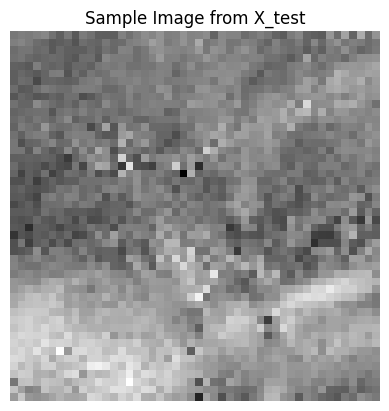

In [45]:
import matplotlib.pyplot as plt

# Assuming X_test is your dataset with shape (696, 48, 48)
# Display the first image in the dataset
plt.imshow(X_test[9], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('Sample Image from X_test')
plt.axis('off')  # Hide the axis
plt.show()

In [32]:
predictions

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 

In [14]:
predictions

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert embeddings to numpy array
embeddings_np = embeddings.numpy()

# Apply UMAP for 2D and 3D reduction
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_2d = umap_2d.fit_transform(embeddings_np)
embeddings_3d = umap_3d.fit_transform(embeddings_np)

# Create 2D scatter plot
plt.figure(figsize=(12, 10))
scatter_labeled = plt.scatter(embeddings_2d[:len(y), 0], embeddings_2d[:len(y), 1], c=y, cmap='coolwarm', alpha=0.7, label='Labeled')
scatter_unlabeled = plt.scatter(embeddings_2d[len(y):, 0], embeddings_2d[len(y):, 1], color='gray', alpha=0.3, label='Unlabeled')
plt.title("2D UMAP Visualization of Crater Image Embeddings")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.colorbar(scatter_labeled)
plt.legend()
plt.show()

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter_labeled = ax.scatter(embeddings_3d[:len(y), 0], embeddings_3d[:len(y), 1], embeddings_3d[:len(y), 2], c=y, cmap='coolwarm', alpha=0.7, label='Labeled')
scatter_unlabeled = ax.scatter(embeddings_3d[len(y):, 0], embeddings_3d[len(y):, 1], embeddings_3d[len(y):, 2], color='gray', alpha=0.3, label='Unlabeled')
ax.set_title("3D UMAP Visualization of Crater Image Embeddings")
ax.set_xlabel("UMAP dimension 1")
ax.set_ylabel("UMAP dimension 2")
ax.set_zlabel("UMAP dimension 3")
plt.colorbar(scatter_labeled)
ax.legend()
plt.show()

In [ ]:
pip install umap

In [ ]:
pip install einops

In [ ]:
pip install nomic